In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import pickle
import os, re
print(os.listdir("../input"))
from nltk.corpus import stopwords

# Any results you write to the current directory are saved as output.

In [ ]:
train = pd.read_csv("../input/labeledTrainData.tsv", header = 0, delimiter = '\t')
test = pd.read_csv("../input/testData.tsv", header = 0, delimiter = '\t')

In [ ]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = test["sentiment"]

In [ ]:
def html_to_text(review):
    """Return extracted text string from provided HTML string."""
    review_text = BeautifulSoup(review, "lxml").get_text()
    if len(review_text) == 0:
        review_text = review
    review_text = re.sub(r"\<.*\>", "", review_text)
    try:
        review_text = review_text.encode('ascii', 'ignore').decode('ascii')#ignore \xc3 etc.
    except UnicodeDecodeError:
        review_text = review_text.decode("ascii", "ignore")
    return review_text


def letters_only(text):
    """Return input string with only letters (no punctuation, no numbers)."""
    # It is probably worth experimenting with milder prepreocessing (eg just removing punctuation)
    return re.sub("[^a-zA-Z]", " ", text)

def rnn_tokenizer_review_preprocess(review):
    """Preprocessing used before fitting/transforming RNN tokenizer - Html->text, remove punctuation/#s, lowercase."""
    return letters_only(html_to_text(review)).lower()

In [ ]:
def get_train_val_data(reviews_to_features_fn=None, df = train):
    """Extracts features (using reviews_to_features_fn), splits into train/test data, and returns
    x_train, y_train, x_test, y_test.  If no feature extraction function is provided, x_train/x_test will
    simply consist of a Series of all the reviews.
    """
#     df = pd.read_csv('labeledTrainData.tsv', header=0, quotechar='"', sep='\t')
    SEED = 1000
    # Shuffle data frame rows
    np.random.seed(SEED)
    df = df.iloc[np.random.permutation(len(df))]

    if reviews_to_features_fn:
        feature_rows = df["review"].map(reviews_to_features_fn)
        if type(feature_rows[0]) == np.ndarray:
            num_instances = len(feature_rows)
            num_features = len(feature_rows[0])
            x = np.concatenate(feature_rows.values).reshape((num_instances, num_features))
        else:
            x = feature_rows
    else:
        x = df["review"]

    y = df["sentiment"]

    # Split 80/20
    test_start_index = int(df.shape[0] * .8)
    x_train = x[0:test_start_index]
    y_train = y[0:test_start_index]
    x_val = x[test_start_index:]
    y_val = y[test_start_index:]

    return x_train, y_train, x_val, y_val

In [ ]:
x_train, y_train, x_val, y_val = get_train_val_data(rnn_tokenizer_review_preprocess)
x_test = test["review"].map(rnn_tokenizer_review_preprocess)
y_test = test["sentiment"]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
np.random.seed(1000)
num_most_freq_words_to_include = 5000
MAX_REVIEW_LENGTH_FOR_KERAS_RNN = 500
embedding_vector_length = 32

In [ ]:
# train_review_list = [s.encode('ascii') for s in x_train.tolist()]
# val_review_list = [s.encode('ascii') for s in x_val.tolist()]
# all_review_list = train_review_list + val_review_list
train_review_list = x_train.tolist()
val_review_list = x_val.tolist()
test_review_list = x_test.tolist()
all_review_list = x_train.tolist() + x_val.tolist()

In [ ]:
tokenizer = Tokenizer(num_words=num_most_freq_words_to_include)
tokenizer.fit_on_texts(all_review_list)

In [ ]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_review_list)
x_train = pad_sequences(train_reviews_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
val_review_tokenized = tokenizer.texts_to_sequences(val_review_list)
x_val = pad_sequences(val_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
test_review_tokenized = tokenizer.texts_to_sequences(test_review_list)
x_test = pad_sequences(test_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)

In [ ]:
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense
from keras.models import Model

In [ ]:
def rnn_model(use_cnn = True, use_lstm = False):
    input_sequences = Input(shape = (MAX_REVIEW_LENGTH_FOR_KERAS_RNN,))
    initial_dropout = 0.2
    embedding_layer = Embedding(input_dim = num_most_freq_words_to_include, 
                                output_dim = embedding_vector_length,
                                input_length = MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
    X = embedding_layer(input_sequences)
    X = Dropout(0.2)(X)
    if use_cnn:
        X = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(X)
        X = MaxPool1D(pool_size=2)(X)
        
    # Add GRU layers
    dropout_W = 0.0
    dropout_U = 0.0
    
    if use_lstm:
        X = LSTM(100, dropout = dropout_W, recurrent_dropout = dropout_U)(X)
    else:
        X = GRU(100, dropout=dropout_W, recurrent_dropout=dropout_U)(X)
    X = Dropout(0.2)(X)
    outputs= Dense(1, activation='sigmoid')(X)
    model = Model(inputs = input_sequences, outputs = outputs)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
gru_model = rnn_model(use_lstm=False)

In [ ]:
gru_model.summary()

In [ ]:
gru_model.fit(x_train, y_train, batch_size=64, epochs=3, validation_data=[x_val, y_val])

In [ ]:
y_test_pred_gru = gru_model.predict(x_test)

In [ ]:
lstm_model = rnn_model(use_lstm=True)
lstm_model.summary()

In [ ]:
lstm_model.fit(x_train, y_train, batch_size = 64, epochs = 3, validation_data=[x_val, y_val])

In [ ]:
y_test_pred_lstm = lstm_model.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print("The AUC socre for GRU model is : %.4f." %roc_auc_score(y_test, y_test_pred_gru))
print("The AUC socre for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))

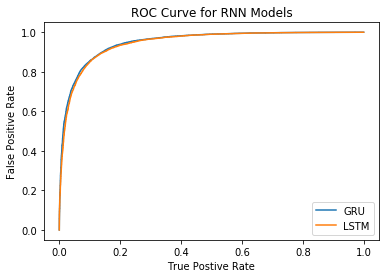

NameError: name 'result' is not defined

In [33]:
y_pred_list = [y_test_pred_gru, y_test_pred_lstm]
label_list = ["GRU", "LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for RNN Models")
plt.legend()
plt.show()
plt.to_csv("samplesubmission.csv", index=False)
